After my, let's say, [_spontaneous_ attempt](https://www.kaggle.com/thiagodsd/nyc-taxi-trip-duration) to find out the duration of taxi trips in New York - which occurs to be my submission ever -, I devote this notebook to study alternative regression approaches and techniques. 

References:

1. [Outlier Detection Practice: uni/multivariate | Kaggle](https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate) - since data cleaning was a step which stuck me a little.

- - -



Checking files:

In [1]:
import numpy  as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyc-taxi-trip-duration/sample_submission.csv
/kaggle/input/nyc-taxi-trip-duration/test.csv
/kaggle/input/nyc-taxi-trip-duration/train.csv
/kaggle/input/nyc-taxi-trip-duration/test/test.csv
/kaggle/input/nyc-taxi-trip-duration/sample_submission/sample_submission.csv
/kaggle/input/nyc-taxi-trip-duration/train/train.csv


Summoning some libs:

In [2]:
import datetime
import warnings
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns
from pandas.plotting import scatter_matrix

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute          import SimpleImputer
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler

from sklearn.cluster      import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.tree         import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_log_error


from IPython.display import display, FileLink

#

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [13, 7]
np.random.seed(1642)

defining some functions:

In [3]:
def var_cleaner(s):
    """
    ('var1, var2, ..., varN') -> None
    """
    trash = list()
    miss  = list()
    for v in s.replace(' ', '').split(','):
        if v in globals():
            del globals()[v]
            trash.append(v)
        else:
            miss.append(v)
    print('- DELETED:     {}'.format( ', '.join(trash) ))
    print('- NOT DEFINED: {}'.format( ', '.join(miss) ))

Loading data:

In [4]:
df_train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.csv')
df_test  = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.csv')

print('train: ', df_train.shape)
print('test:  ', df_test.shape)

display( df_train.head() )
display( df_test.head() )

train:  (1458644, 11)
test:   (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
_TARGET      = 'trip_duration'
_NON_FEATURE = set(df_train.columns) - set(df_test.columns)
_FEATURES    = set(df_train.columns).intersection(set(df_test.columns)) - set(['id'])

display(_FEATURES)

{'dropoff_latitude',
 'dropoff_longitude',
 'passenger_count',
 'pickup_datetime',
 'pickup_latitude',
 'pickup_longitude',
 'store_and_fwd_flag',
 'vendor_id'}

In [6]:
train = df_train[_FEATURES]
test  = df_test[_FEATURES]

In [7]:
train.describe().apply( lambda s: s.apply( lambda x: format(x, '.3f') ) )

,pickup_longitude,passenger_count,dropoff_latitude,pickup_latitude,dropoff_longitude,vendor_id
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,-73.973,1.665,40.752,40.751,-73.973,1.535
std,0.071,1.314,0.036,0.033,0.071,0.499
min,-121.933,0.000,32.181,34.360,-121.933,1.000
25%,-73.992,1.000,40.736,40.737,-73.991,1.000
50%,-73.982,1.000,40.755,40.754,-73.980,2.000
75%,-73.967,2.000,40.770,40.768,-73.963,2.000
max,-61.336,9.000,43.921,51.881,-61.336,2.000


In [18]:
sample = train[['dropoff_latitude', 'dropoff_longitude']].sample(10000)

# Outlier Detection

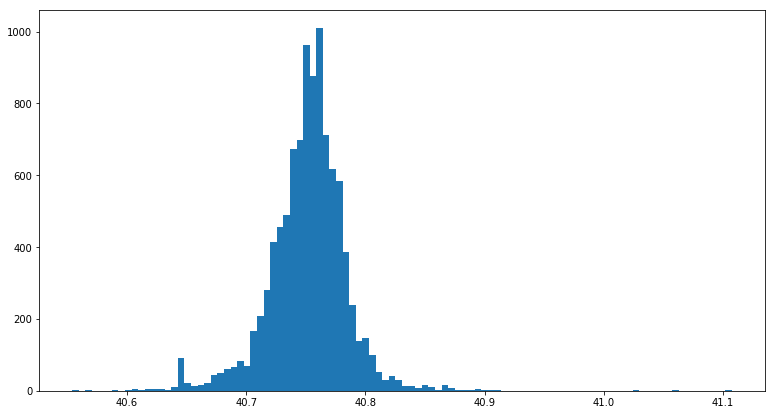

In [19]:
plt.hist(sample['dropoff_latitude'], bins=100);

## Univariate

### Standard Deviation & Interquartile Range Method

> A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

In [20]:
def out_std(data, n_std=3.0, return_thresholds=False):
    """
    ref: https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate#Parametric-methods:-Univariate
    """
    mean, std    = data.mean(), data.std()
    cutoff       = std * n_std
    lower, upper = mean - cutoff, mean + cutoff
    if return_thresholds:
        return lower, upper
    return [True if i < lower or i > upper else False for i in data]

def out_iqr(data, k=1.5, return_thresholds=False):
    """
    ref: https://www.kaggle.com/kevinarvai/outlier-detection-practice-uni-multivariate#Parametric-methods:-Univariate
    """
    q25, q75     = np.percentile(data, 25), np.percentile(data, 75)
    iqr          = q75 - q25
    cutoff       = iqr * k
    lower, upper = q25 - cutoff, q75 + cutoff
    if return_thresholds:
        return lower, upper
    return [True if i < lower or i > upper else False for i in data]

In [21]:
out_mask_std = out_std(sample['dropoff_latitude'], n_std=3.0)
display( np.unique(out_mask_std, return_counts=True) )

out_mask_iqr = out_iqr(sample['dropoff_latitude'], k=1.5)
display( np.unique(out_mask_iqr, return_counts=True) )

(array([False,  True]), array([9781,  219]))

(array([False,  True]), array([9496,  504]))

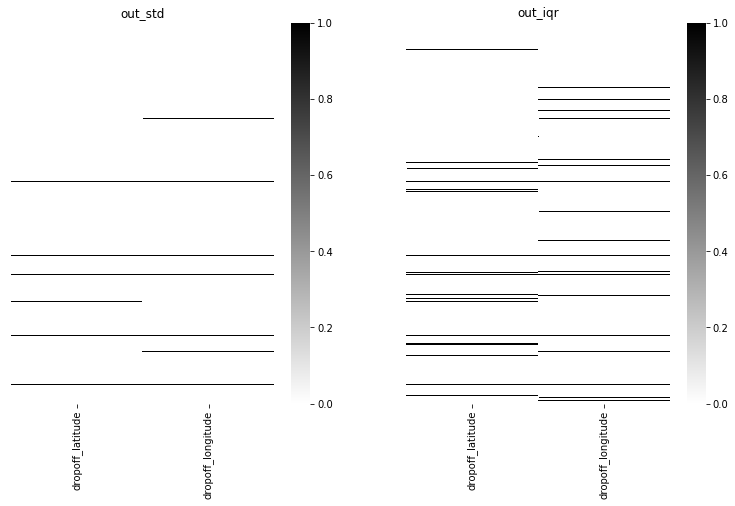

In [22]:
_filter = sample.dtypes[~(sample.dtypes.isin([ np.dtype('object'),  np.dtype('<M8[ns]')]))].index

out_mask_std = sample[_filter].apply(out_std, n_std=3.0)
out_mask_iqr = sample[_filter].apply(out_iqr, k=1.5)

f, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1)

sns.heatmap(out_mask_std, cmap='binary', ax=ax1)
sns.heatmap(out_mask_iqr, cmap='binary', ax=ax2)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.axes.get_yaxis().set_visible(False)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.axes.get_yaxis().set_visible(False)

ax1.set_title(r'out_std')
ax2.set_title(r'out_iqr');

### Isolation Forest

In [23]:
from sklearn.ensemble import IsolationForest

out_if = IsolationForest(n_estimators=100)
out_if.fit(sample['dropoff_latitude'].values.reshape(-1, 1))

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

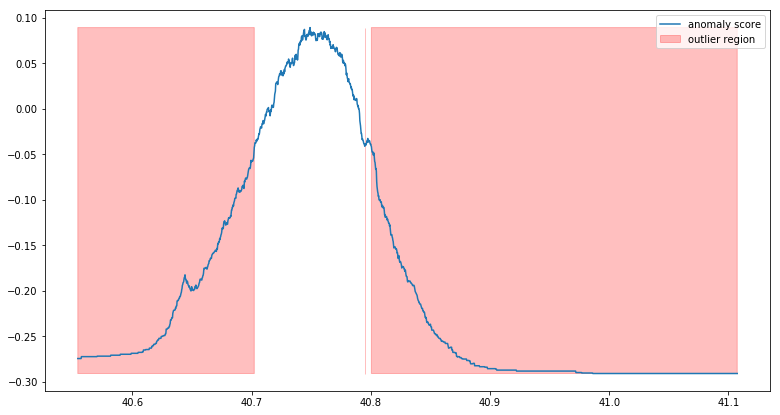

In [24]:
xx = np.linspace(sample['dropoff_latitude'].min(), sample['dropoff_latitude'].max(), int(sample.shape[0]/5.0)).reshape(-1, 1)

anomaly_score = out_if.decision_function(xx)
out_bounds    = out_if.predict(xx)

plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score),  np.max(anomaly_score), where=(out_bounds==-1), alpha=.25, color='r', label='outlier region')

plt.legend();

## Multivariate

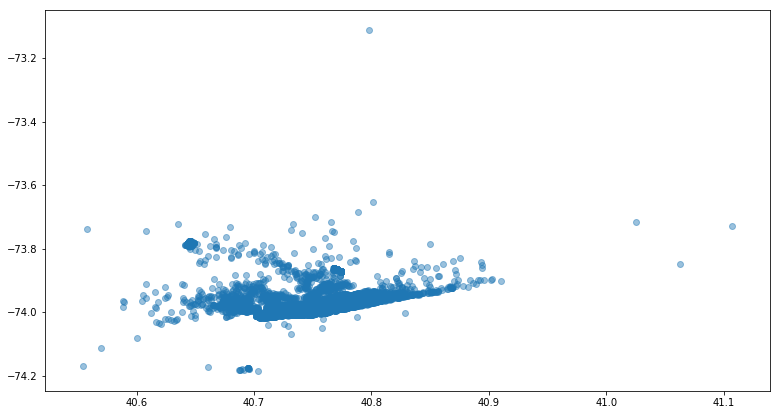

In [25]:
plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);

### Isolation Forest

In [34]:
from sklearn.ensemble import IsolationForest

out_if = IsolationForest()
out_if.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

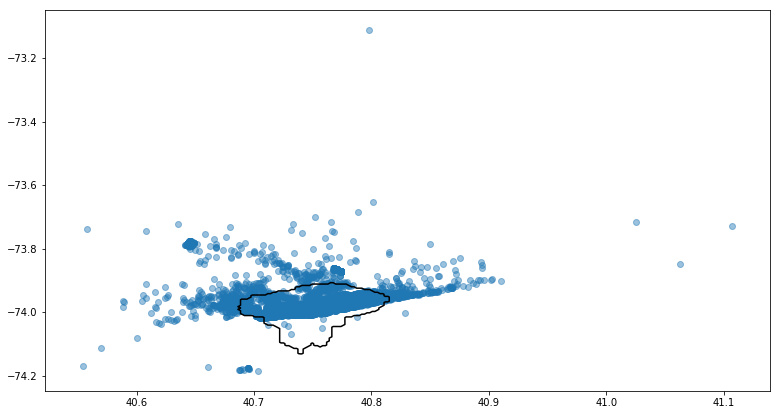

In [39]:
xx_bounds = [sample['dropoff_latitude'].min(), sample['dropoff_latitude'].max()]
yy_bounds = [sample['dropoff_longitude'].min(), sample['dropoff_longitude'].max()]

xx, yy = np.meshgrid(np.linspace(min(xx_bounds), max(xx_bounds), 250),
                    np.linspace(min(yy_bounds), max(yy_bounds), 250))

zz = out_if.predict(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');

### Elliptic Envelope

In [37]:
from sklearn.covariance import EllipticEnvelope

out_elp = EllipticEnvelope()
out_elp.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
                 store_precision=True, support_fraction=None)

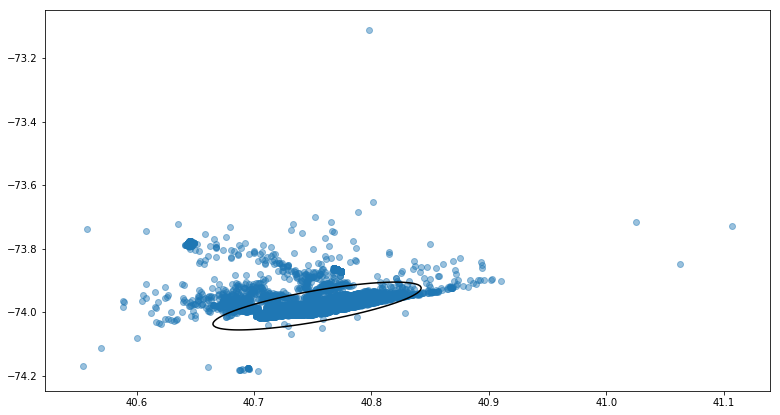

In [40]:
zz = out_elp.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');

### DBSCAN

In [53]:
from sklearn.preprocessing  import StandardScaler
from sklearn.cluster        import DBSCAN

X      = StandardScaler().fit_transform(sample.values)
out_db = DBSCAN(eps=0.75, min_samples=10).fit(X)
labels = out_db.labels_

np.unique(labels, return_counts=True)

(array([-1,  0,  1]), array([  38, 9946,   16]))

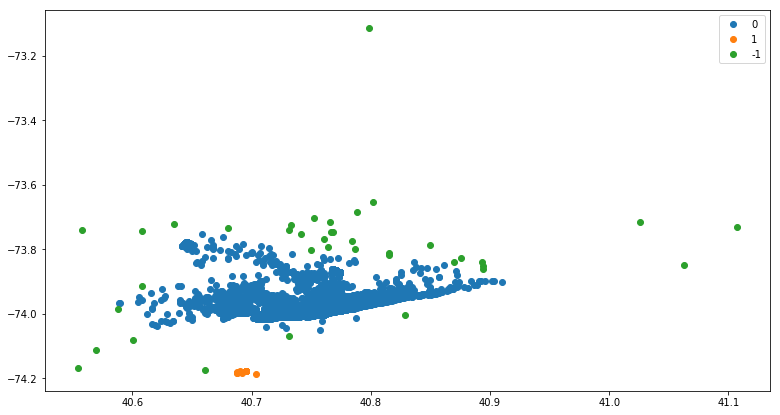

In [54]:
unique_labels = set(labels)

for label in unique_labels:
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(sample['dropoff_latitude'][sample_mask], sample['dropoff_longitude'][sample_mask], 'o', label=label);
plt.legend();

### Local Outlier Factor

>  The advantage of sklearn.neighbors.LocalOutlierFactor over the other estimators is shown for the third data set, where the two modes have different densities. This advantage is explained by the local aspect of LOF, meaning that it only compares the score of abnormality of one sample with the scores of its neighbors.

In [63]:
from sklearn.neighbors import LocalOutlierFactor

out_lof = LocalOutlierFactor(n_neighbors=10, novelty=True)
out_lof.fit(sample[['dropoff_latitude', 'dropoff_longitude']])

LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=10, novelty=True, p=2)

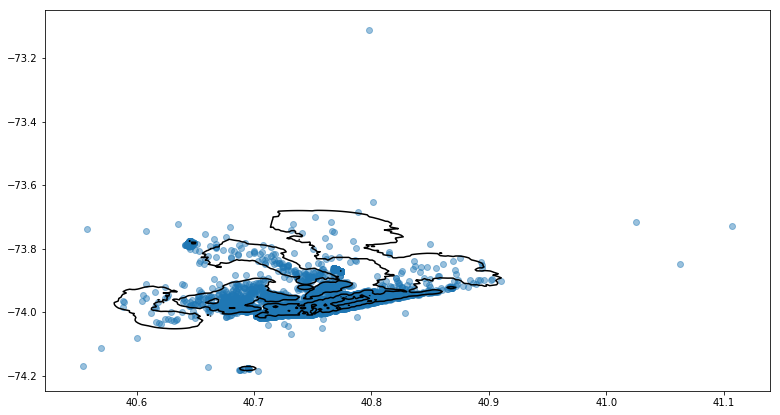

In [64]:
zz = out_lof.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

plt.scatter(sample['dropoff_latitude'], sample['dropoff_longitude'], alpha=0.45);
plt.contour(xx, yy, zz, levels=[0], colors='black');